In [1]:
using Pkg
Pkg.activate("..")
Pkg.resolve() 
Pkg.instantiate()
using DifferentialEquations,JPEC, Plots, DelimitedFiles

  Activating project at `~/Desktop/JPEC`
  No Changes to `~/Desktop/JPEC/Project.toml`
  No Changes to `~/Desktop/JPEC/Manifest.toml`


In [2]:
equil_input = JPEC.Equilibrium.EquilConfig(; control=JPEC.Equilibrium.EquilControl(eq_type="lar", eq_filename="lar.toml"), output=JPEC.Equilibrium.EquilOutput())
lar_input = JPEC.Equilibrium.LargeAspectRatioConfig(; lar_r0=10, lar_a=1, beta0=0.001, q0=1.5, p_pres=2, p_sig=1)

┌ Info: Forcing hamada coordinate jacobian exponents: power_*
└ @ JPEC.Equilibrium /Users/iseonjae/Desktop/JPEC/src/Equilibrium/EquilibriumTypes.jl:48


JPEC.Equilibrium.LargeAspectRatioConfig(10.0, 1.0, 0.001, 1.5, 2.0, 1.0, "default", 128, 128, false)

In [3]:
plasma_eq= JPEC.Equilibrium.setup_equilibrium(equil_input, lar_input)

Equilibrium file: lar.toml
--- Starting Inverse Equilibrium Processing ---
--- Equilibrium Setup Complete ---


JPEC.Equilibrium.PlasmaEquilibrium(JPEC.Equilibrium.EquilConfig(JPEC.Equilibrium.EquilControl("lar", "lar.toml", "hamada", 0, 0, 0, "ldp", 0.01, 0.994, 128, 256, 0, 1.0e-7, false, false, true), JPEC.Equilibrium.EquilOutput(false, false, false, false, true, false, false, false)), JPEC.SplinesMod.RealSplineType(Ptr{Nothing} @0x0000000334f82500, [0.01, 0.010148181201467524, 0.010592635547055184, 0.011333095314084414, 0.012369114477279132, 0.013700068977434681, 0.015325157097327761, 0.017243399944640907, 0.019453642041610618, 0.021954552021043953  …  0.9820454479789561, 0.9845463579583893, 0.986756600055359, 0.9886748429026722, 0.9902999310225652, 0.9916308855227208, 0.9926669046859157, 0.9934073644529449, 0.9938518187985325, 0.994], [62.830366651502736 0.0004930704809030368 137.73806992066977 1.5104834926070352; 62.83034482525349 0.0004929677989738323 137.75220208788392 1.510639573383075; … ; 62.75886344741364 3.618352407563644e-8 271.26740766931823 3.0182438420917856; 62.758856325965404 


--- Generating data for 2D color plots ---
Evaluating the 'rzphi' mapping spline...
Evaluation complete.
Calculated R and Z grids.
--- Plotting heatmap for R(ψ,θ) ---
--- Plotting heatmap for Z(ψ,θ) ---

2D color plots for R and Z have been saved.


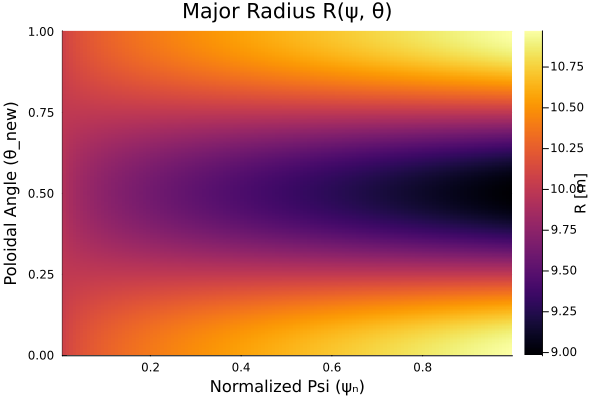

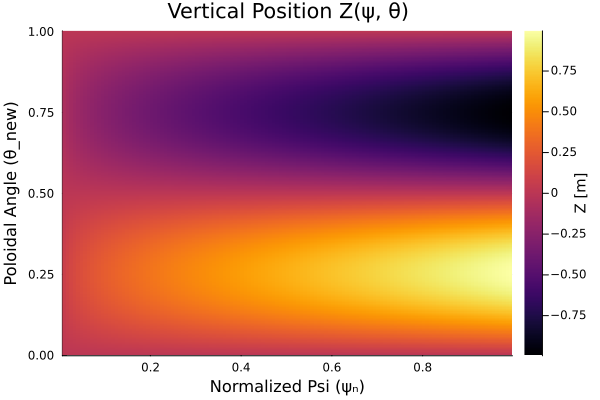

In [5]:
# --- Final Code to Generate 2D Color Plots of R(ψ,θ) and Z(ψ,θ) ---
println("\n--- Generating data for 2D color plots ---")
# 1. Define the grid in flux coordinates (ψ_norm, θ_new)
# This part is identical to the previous steps.
equil_control = plasma_eq.config.control
psi_norm_grid = collect(range(equil_control.psilow, equil_control.psihigh, length=equil_control.mpsi + 1))
theta_new_grid = collect(range(0.0, 1.0, length=equil_control.mtheta + 1))
# 2. Evaluate the `rzphi` spline to get the R and Z values.
println("Evaluating the 'rzphi' mapping spline...")
fs_grid = JPEC.Spl.bicube_eval(plasma_eq.rzphi, psi_norm_grid, theta_new_grid)
println("Evaluation complete.")
# 3. Transform the spline output to physical (R, Z) coordinates.
# This calculates R_grid[i,j] = R(ψ[i], θ[j]) and Z_grid[i,j] = Z(ψ[i], θ[j])
rfac_sq = fs_grid[:, :, 1]
eta_term = fs_grid[:, :, 2]
theta_new_mesh = ones(length(psi_norm_grid)) * theta_new_grid'
eta_grid = 2.0 * pi .* (theta_new_mesh .+ eta_term)
rfac_grid = sqrt.(max.(0.0, rfac_sq))
R_grid = plasma_eq.ro .+ rfac_grid .* cos.(eta_grid)
Z_grid = plasma_eq.zo .+ rfac_grid .* sin.(eta_grid)
println("Calculated R and Z grids.")
# 4. Create the 2D color plot for R(ψ,θ)
println("--- Plotting heatmap for R(ψ,θ) ---")
p_r_heatmap = heatmap(
    psi_norm_grid,
    theta_new_grid,
    R_grid',  # Note the transpose ' to match axis dimensions
    title="Major Radius R(ψ, θ)",
    xlabel="Normalized Psi (ψₙ)",
    ylabel="Poloidal Angle (θ_new)",
    colorbar_title="R [m]"
)
display(p_r_heatmap)
# 5. Create the 2D color plot for Z(ψ,θ)
println("--- Plotting heatmap for Z(ψ,θ) ---")
p_z_heatmap = heatmap(
    psi_norm_grid,
    theta_new_grid,
    Z_grid',  # Note the transpose ' to match axis dimensions
    title="Vertical Position Z(ψ, θ)",
    xlabel="Normalized Psi (ψₙ)",
    ylabel="Poloidal Angle (θ_new)",
    colorbar_title="Z [m]"
)
display(p_z_heatmap)
println("\n2D color plots for R and Z have been saved.")

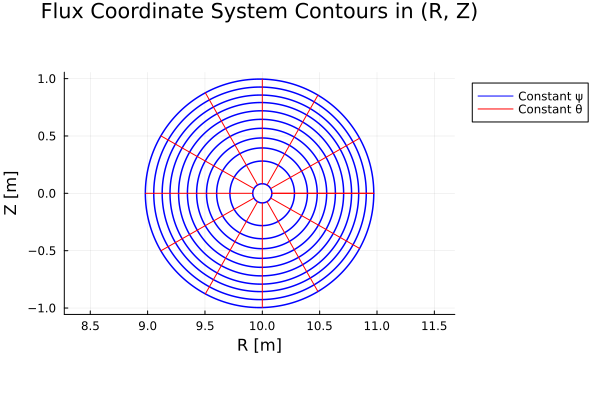


--- Plotting Psi and Theta Contours in R-Z Space ---
Flux surface contour plot saved as 'flux_surfaces_RZ.png'


In [6]:
# --- Code to Plot Psi and Theta Contours in R-Z Space ---
# This code block goes at the end of your existing script.

println("\n--- Plotting Psi and Theta Contours in R-Z Space ---")

# 1. Select a number of contours to display for clarity
num_psi_contours = 11   # e.g., from ψ_norm = 0.0 to 1.0 in steps of 0.1
num_theta_contours = 13 # e.g., every 30 degrees

# 2. Initialize the plot
#    aspect_ratio=:equal is crucial for tokamak plots to look physically correct.
p_flux_surfaces = plot(
    title="Flux Coordinate System Contours in (R, Z)",
    xlabel="R [m]",
    ylabel="Z [m]",
    aspect_ratio=:equal,
    legend=:outertopright
)

# 3. Plot contours of constant ψ (flux surfaces) in blue
#    We loop through the ROWS of the R_grid and Z_grid matrices.
psi_indices = round.(Int, range(1, stop=size(R_grid, 1), length=num_psi_contours))

for i in psi_indices
    # Each row corresponds to a single psi value
    # We must add the last point to the start to close the loop for a smooth plot
    R_surface = [R_grid[i, :]; R_grid[i, 1]]
    Z_surface = [Z_grid[i, :]; Z_grid[i, 1]]
    plot!(p_flux_surfaces, R_surface, Z_surface, label="", color=:blue, linewidth=1.5)
end

# 4. Plot contours of constant θ (angle contours) in red
#    We loop through the COLUMNS of the R_grid and Z_grid matrices.
theta_indices = round.(Int, range(1, stop=size(R_grid, 2), length=num_theta_contours))

for j in theta_indices
    # Each column corresponds to a single theta value
    plot!(p_flux_surfaces, R_grid[:, j], Z_grid[:, j], label="", color=:red, linewidth=1)
end

# 5. Add a legend manually (a common trick in Plots.jl)
plot!(p_flux_surfaces, [], [], color=:blue, label="Constant ψ")
plot!(p_flux_surfaces, [], [], color=:red, label="Constant θ")

# 6. Display and save the final plot
display(p_flux_surfaces)
println("Flux surface contour plot saved as 'flux_surfaces_RZ.png'")

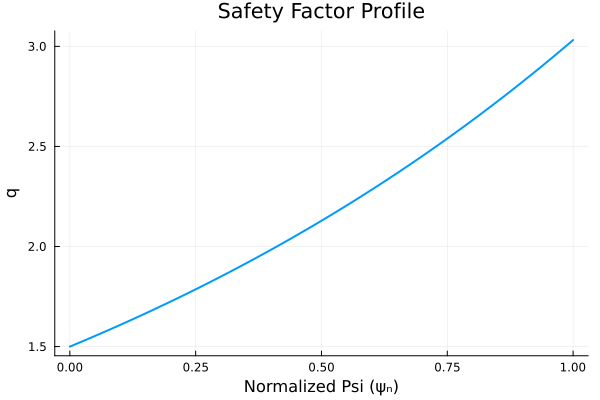

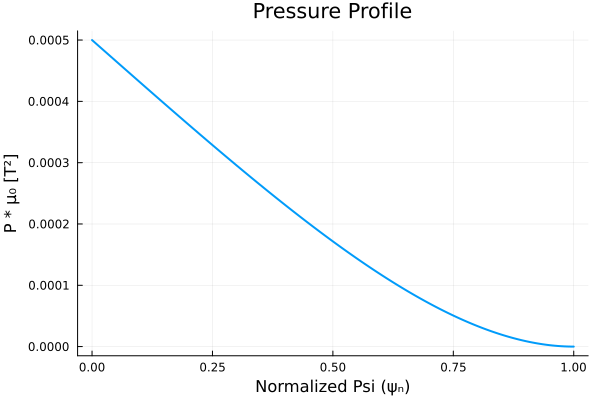

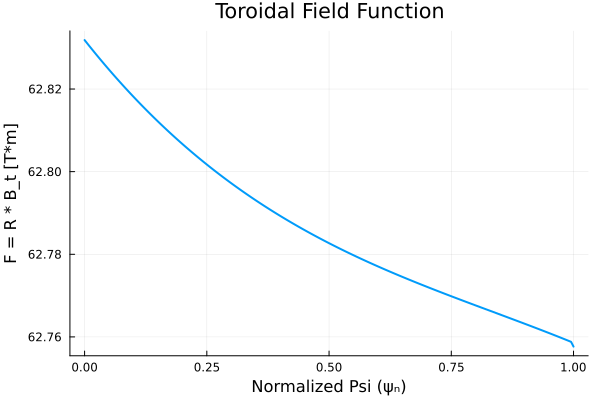

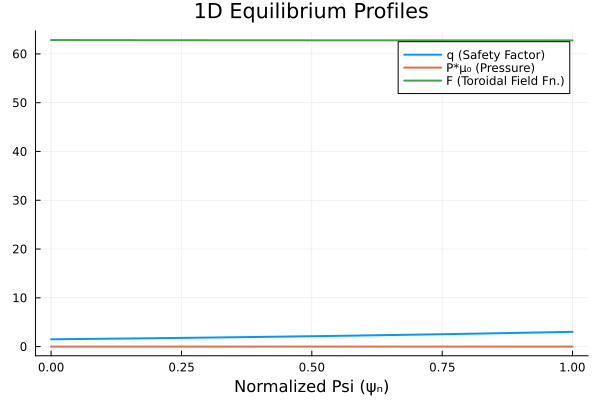


--- Plotting 1D Profiles from 'sq' Spline ---
Evaluating 'sq' spline on a dense grid...
Evaluation complete.
1D profile plots saved successfully.


In [4]:
# --- Code to Plot 1D Profiles from the 'sq' Spline ---
# This code block goes at the end of your existing script.

println("\n--- Plotting 1D Profiles from 'sq' Spline ---")

# 1. To get smooth curves, we'll evaluate the spline on a dense grid,
#    not just on its internal knot points.
psi_eval_grid = range(0.0, 1.0, length=200)

# 2. Evaluate the 'sq' spline across this dense grid.
#    Calling spline_eval with a vector input is efficient and returns a matrix
#    where each column corresponds to one of the splined quantities.
println("Evaluating 'sq' spline on a dense grid...")
evaluated_profiles = JPEC.Spl.spline_eval(plasma_eq.sq, collect(psi_eval_grid), 0)
println("Evaluation complete.")

# 3. Extract each profile into its own variable for clarity.
#    Based on the direct_run implementation:
#    Column 1: F = R*Bt (Toroidal Field Function)
#    Column 2: P*μ₀ (Scaled Pressure)
#    Column 3: Toroidal Flux function (related to dV/dψ_pol)
#    Column 4: q (Safety Factor)
F_profile = evaluated_profiles[:, 1]
P_profile = evaluated_profiles[:, 2]
Flux_profile = evaluated_profiles[:, 3]
q_profile = evaluated_profiles[:, 4]

# 4. Create and display the plots

# Plot 1: Safety Factor (q)
p_q = plot(
    psi_eval_grid,
    q_profile,
    title="Safety Factor Profile",
    xlabel="Normalized Psi (ψₙ)",
    ylabel="q",
    legend=false,
    linewidth=2
)
display(p_q)

# Plot 2: Scaled Pressure (P*μ₀)
p_p = plot(
    psi_eval_grid,
    P_profile,
    title="Pressure Profile",
    xlabel="Normalized Psi (ψₙ)",
    ylabel="P * μ₀ [T²]",
    legend=false,
    linewidth=2
)
display(p_p)


# Plot 3: Toroidal Field Function (F)
p_f = plot(
    psi_eval_grid,
    F_profile,
    title="Toroidal Field Function",
    xlabel="Normalized Psi (ψₙ)",
    ylabel="F = R * B_t [T*m]",
    legend=false,
    linewidth=2
)
display(p_f)

# Plot 4: Combined plot for comparison
p_all_profiles = plot(
    title="1D Equilibrium Profiles",
    xlabel="Normalized Psi (ψₙ)",
    legend=:best
)
plot!(p_all_profiles, psi_eval_grid, q_profile, label="q (Safety Factor)", linewidth=2)
plot!(p_all_profiles, psi_eval_grid, P_profile, label="P*μ₀ (Pressure)", linewidth=2)
plot!(p_all_profiles, psi_eval_grid, F_profile, label="F (Toroidal Field Fn.)", linewidth=2)
# We can also plot the 3rd quantity, though it's less commonly viewed.
# plot!(p_all_profiles, psi_eval_grid, Flux_profile, label="Toroidal Flux Fn.", linewidth=2)
display(p_all_profiles)


println("1D profile plots saved successfully.")